In [1]:
# Import required packages.
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from openai import AzureOpenAI
import json
import os
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
#Manually Set configurations
EMBDEDDING_ENDPOINT='<Azure OpenAI Endpoint>'
EMBEDDING_KEY='<Key>'
EMBEDDING_MODEL_NAME='<Model Name>'
EMBEDDING_VERSION='<Model Version>'


In [89]:
#Read Configurations from environmental variables.
EMBDEDDING_ENDPOINT=os.getenv("EMBDEDDING_ENDPOINT")
EMBEDDING_KEY=os.getenv("KEY")
EMBEDDING_MODEL_NAME=os.getenv("MODEL_NAME")
EMBEDDING_VERSION=os.getenv("VERSION")

In [3]:
#Initialize OpenAI Client
client = AzureOpenAI(
  api_key = EMBEDDING_KEY,  
  api_version = EMBEDDING_VERSION,
  azure_endpoint=EMBDEDDING_ENDPOINT
)

In [4]:
#Function to connect to embedding model and get embeddings for a given word(s)
def generate_embeddings(word):
    response = client.embeddings.create(
                    input = word,
                    model= EMBEDDING_MODEL_NAME
                )
    response = json.loads(response.model_dump_json())
    embeddings = response['data'][0]['embedding']
    return embeddings

In [19]:
# plot visualizations (heatmaps, historgrams) for embeddings.
def plot_embedding(embeddings_list):
    cols = 3
    fig,axes = plt.subplots(nrows=int(len(embeddings_list)/cols),ncols=cols,sharex=False,sharey=True,figsize=(20,20))
    rows = len(axes)
    fig.suptitle("Comparing embedding vectors")
    i = 0
    for row in range(0,rows,1):
        for col in range(0,cols,1):
            axes[row,col].set_title(embeddings_list[i]['word'])
            sns.histplot(
                            ax=axes[row,col],
                            data=embeddings_list[i]['filtered_df'],
                            x="col_x",
                            hue='cat',
                            stat='frequency',
                            element='step',
                            common_norm=False                            
                        )
            i = i + 1


In [6]:
# compute Similarity metrics
def compute_similarity(vec1,vec2):
    similarity_score = cosine_similarity(vec1,vec2)
    print(similarity_score)

In [20]:
def compare_embeddings(words:list):
    embeddings = []
    for word in words:
        embedding_metadata = {}
        word_embedding = pd.array(generate_embeddings(word))
        embedding_metadata['word'] = word
        embedding_metadata['embeddings'] = word_embedding
        spc = np.linspace(word_embedding.min(),word_embedding.max(),num=10)
        spc = np.round(spc,1)
        df = pd.DataFrame({'col_x':word_embedding})
        labels = ["-0.7","-0.6","-0.5","-0.4","-0.3","-0.2","-0.1","0.0","0.1"]
        cat = pd.cut(df["col_x"],bins=spc,labels=labels)
        df.insert(1,"cat",cat)
        filtered_df = df[(df['cat'] == '-0.1') | (df['cat'] == '0.0')]
        embedding_metadata['raw_df'] = df
        embedding_metadata["filtered_df"] = filtered_df
        embeddings.append(embedding_metadata)
    plot_embedding(embeddings_list=embeddings)

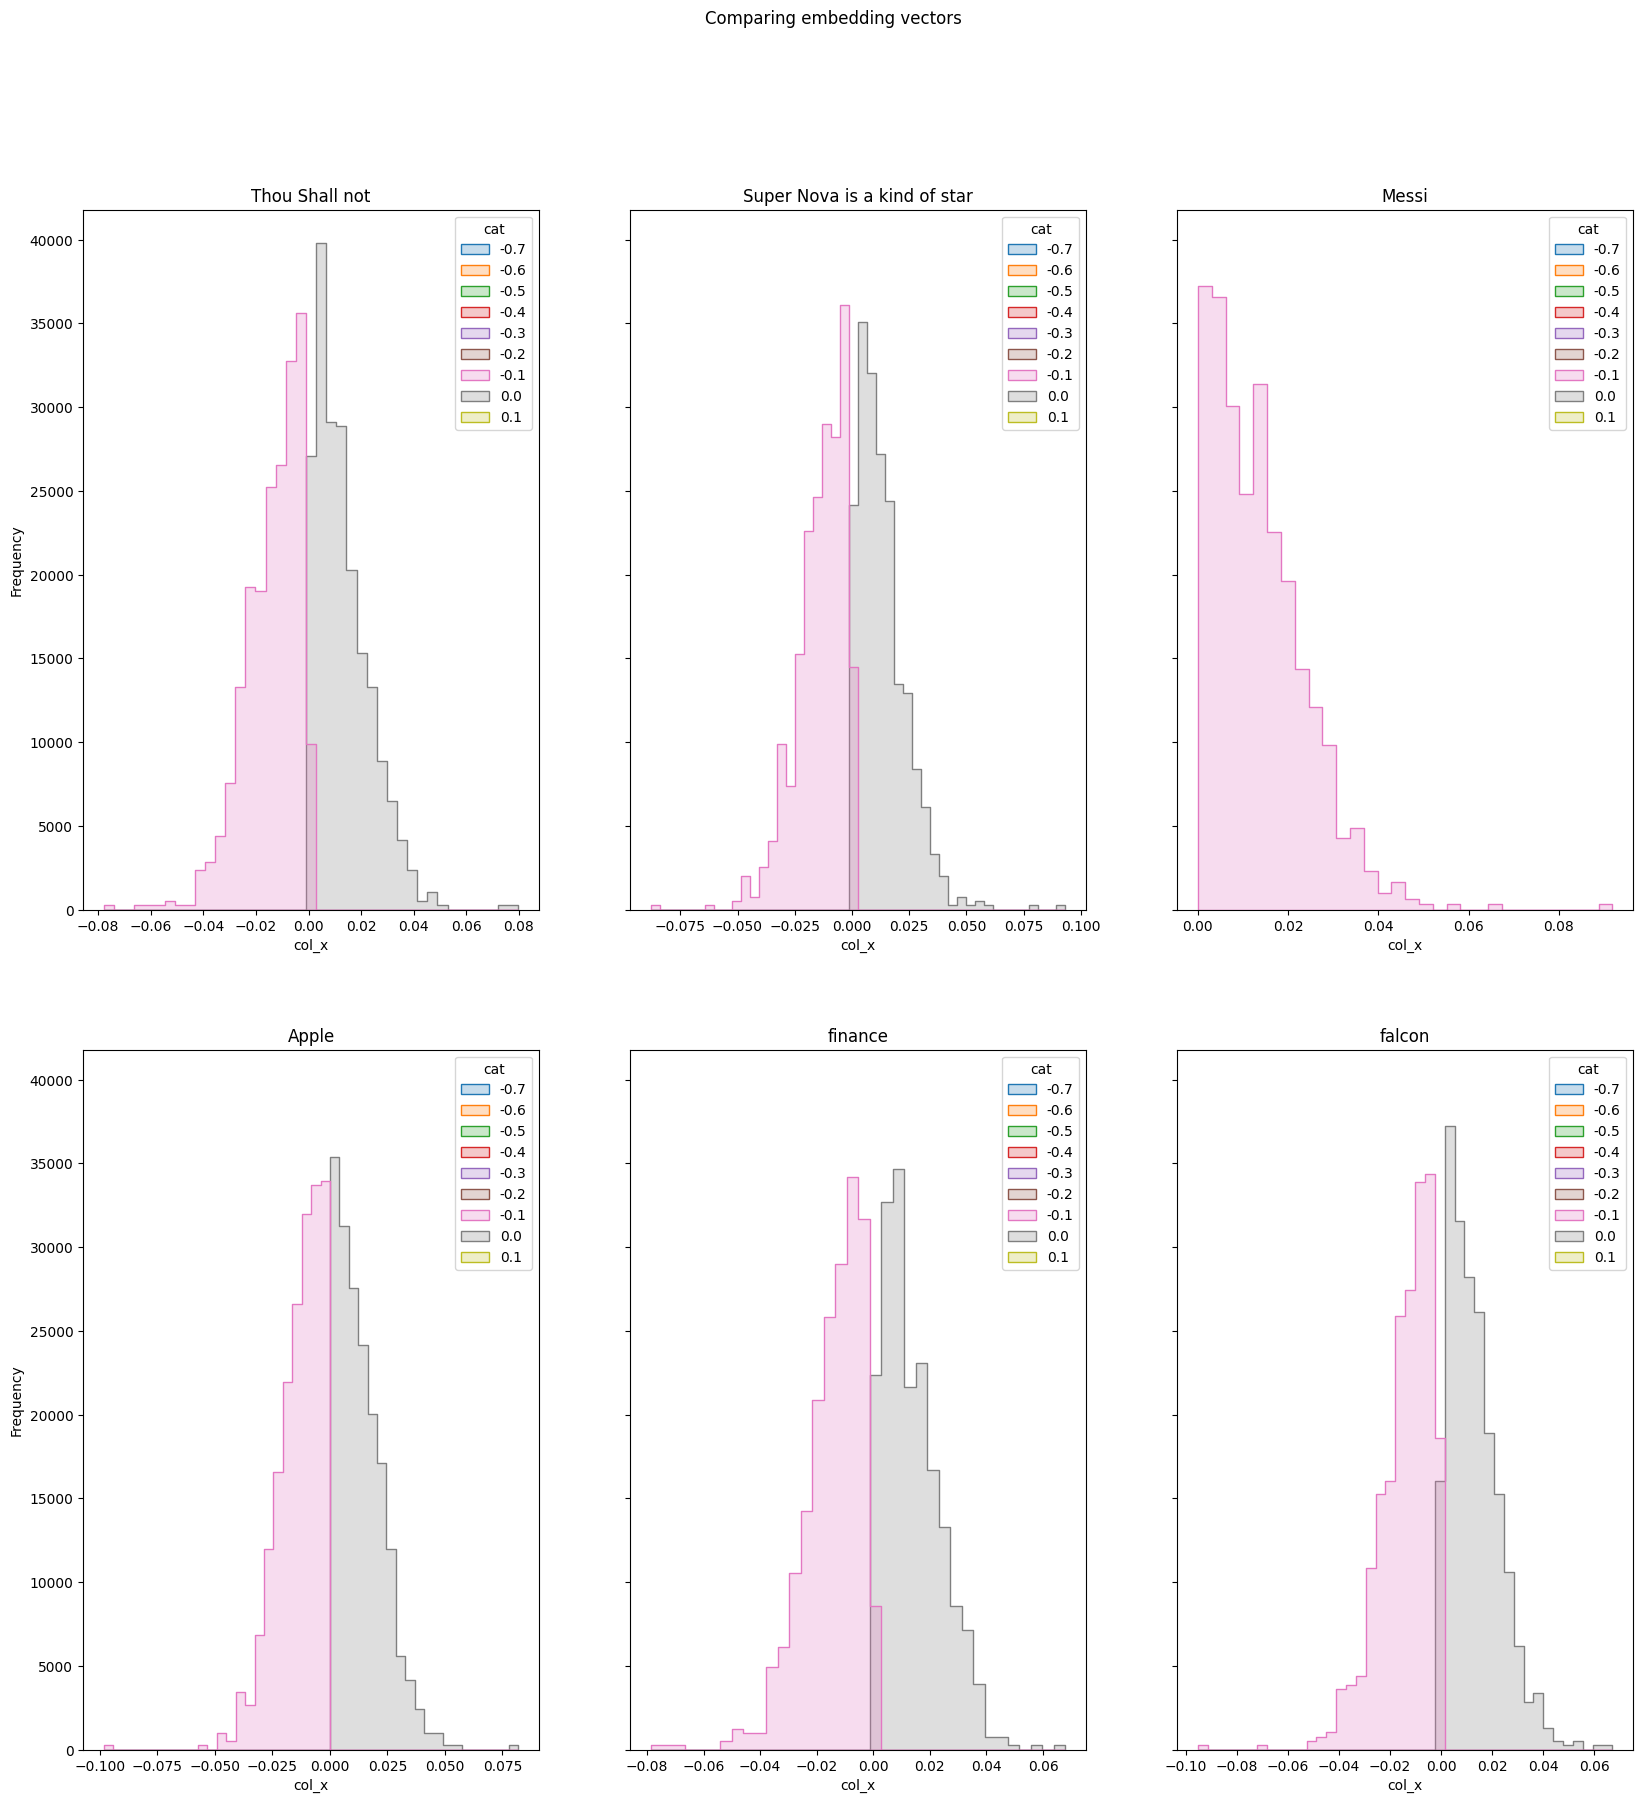

In [21]:
words = ["Thou Shall not","Super Nova is a kind of star","Messi","Apple","finance","falcon"]
compare_embeddings(words)